### Checklist for submission

It is extremely important to make sure that:

1. Everything runs as expected (no bugs when running cells);
2. The output from each cell corresponds to its code (don't change any cell's contents without rerunning it afterwards);
3. All outputs are present (don't delete any of the outputs);
4. Fill in all the places that say `# YOUR CODE HERE`, or "**Your answer:** (fill in here)".
5. Never copy/paste any notebook cells. Inserting new cells is allowed, but it should not be necessary.
6. The notebook contains some hidden metadata which is important during our grading process. **Make sure not to corrupt any of this metadata!** The metadata may for example be corrupted if you copy/paste any notebook cells, or if you perform an unsuccessful git merge / git pull. It may also be pruned completely if using Google Colab, so watch out for this. Searching for "nbgrader" when opening the notebook in a text editor should take you to the important metadata entries.
7. Although we will try our very best to avoid this, it may happen that bugs are found after an assignment is released, and that we will push an updated version of the assignment to GitHub. If this happens, it is important that you update to the new version, while making sure the notebook metadata is properly updated as well. The safest way to make sure nothing gets messed up is to start from scratch on a clean updated version of the notebook, copy/pasting your code from the cells of the previous version into the cells of the new version.
8. If you need to have multiple parallel versions of this notebook, make sure not to move them to another directory.
9. Although not forced to work exclusively in the course Docker environment, you need to make sure that the notebook will run in that environment, i.e. that you have not added any additional dependencies.

Failing to meet any of these requirements might lead to either a subtraction of POEs (at best) or a request for resubmission (at worst).

We advise you the following steps before submission for ensuring that requirements 1, 2, and 3 are always met: **Restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). This might require a bit of time, so plan ahead for this (and possibly use Google Cloud's GPU in HA1 and HA2 for this step). Finally press the "Save and Checkout" button before handing in, to make sure that all your changes are saved to this .ipynb file.

### Fill in name of notebook file
This might seem silly, but the version check below needs to know the filename of the current notebook, which is not trivial to find out programmatically.

You might want to have several parallel versions of the notebook, and it is fine to rename the notebook as long as it stays in the same directory. **However**, if you do rename it, you also need to update its own filename below:

In [1]:
nb_fname = "HA2-Part2.ipynb"

### Fill in group number and member names:

In [2]:
GROUP = "67"
NAME1 = "Tobias Sundell"
NAME2 = "Qingbo Zhu"

### Check Python version

In [3]:
from platform import python_version_tuple
assert python_version_tuple()[:2] == ('3','7'), "You are not running Python 3.7. Make sure to run Python through the course Docker environment, or alternatively in the provided Conda environment."

### Check that notebook server has access to all required resources, and that notebook has not moved

In [4]:
import os
nb_dirname = os.path.abspath('')
assert nb_dirname != '/workspace', \
    '[ERROR] The notebook server appears to have been started via Docker, at the same directory as the assignment. Make sure to start it at least one level above the assignment.'
assignment_name = os.path.basename(nb_dirname)
assert assignment_name in ['IHA1', 'IHA2', 'HA1', 'HA2', 'HA3'], \
    '[ERROR] The notebook appears to have been moved from its original directory'

### Verify correct nb_fname

In [5]:
from IPython.display import display, HTML
try:
    display(HTML(r'<script>if("{nb_fname}" != IPython.notebook.notebook_name) {{ alert("You have filled in nb_fname = \"{nb_fname}\", but this does not seem to match the notebook filename \"" + IPython.notebook.notebook_name + "\"."); }}</script>'.format(nb_fname=nb_fname)))
except NameError:
    assert False, 'Make sure to fill in the nb_fname variable above!'

### Verify that your notebook is up-to-date and not corrupted in any way

In [6]:
import sys
sys.path.append('..')
from ha_utils import check_notebook_uptodate_and_not_corrupted
check_notebook_uptodate_and_not_corrupted(nb_dirname, nb_fname)

Matching current notebook against the following URL:
http://raw.githubusercontent.com/JulianoLagana/deep-machine-learning/master/home-assignments/HA2/HA2-Part2.ipynb
[SUCCESS] No major notebook mismatch found when comparing to latest GitHub version. (There might be minor updates, but even that is the case, submitting your work based on this notebook version would be acceptable.)


![test](data/translate.png)

## Task 2 - Neural Machine Translation

In this task you will build a system that uses recurrent neural networks to translate sentences from English to Spanish! 

Before we start coding anything, it's important to clear up some details about neural machine translation and make sure everyone is on the same page regarding conventions, etc. Please read the next section carefully and make sure you understand the specifics of the solution we will develop in this task.

### 2.0 Preliminaries

For this translation task, we'll use an encoder-decoder architecture. The input sentence (in English) will be first processed by the encoder, which will output its hidden state at the last time-step. After that, this hidden state will be fed as the initial state for the decoder, which will generate the output sentence (in Spanish). The following diagram illustrates the process:

![nmt_teacher_forcing](data/nmt_diagram.png)

We feed one word of the input sentence at a time (first `i`, then `am`, then `happy`) to the encoder, which processes it and computes its next hidden state. Once the last word of the input sentence is processed by the encoder, we feed its current hidden state to the decoder.

The decoder then uses this hidden state as initial state, together with a special word token that we feed as input, which signifies the "start of sentence", `<SOS>`. This tells the decoder it should start generating the output sentence.

The decoder then produces a probability distribution over possible spanish words for the first position. We sample from this distribution to obtain one word, which in this case the sample was `estoy`. This output is now the first word of the generated translation. In order to generate the next word, we feed the sample `estoy` as input to the decoder in the next time-step, which then produces a new probability distribution over possible spanish words again, from which we sampled `feliz` in the example. This process continues until it produces the special word token `<EOS>`, which signifies the end of the sentence (or until a maximum number of words have been generated).

Because of this connection from output to input, this type of architecture can be challenging to train. One commonly used technique to circumvent this problem is called *teacher forcing*. In it, instead of feeding the output at time-step $t$ as input to time-step $t+1$, we use as input the *ground-truth label* for time-step $t+1$. The following diagram illustrates it:

![nmt_teacher_forcing](data/nmt_teacher_forcing.png)

Note how in this example the model incorrectly predicted `estas` as the first word in the translation. However, instead of feeding it as input to the next time-step, and making it more likely to also misclassify the next word, we feed the *ground-truth label* as input, `estoy`, here shown in green. We continue this process until we fed all of the ground-truth words to the decoder (regardless of whether the model predicts `<EOS>` or not).

### 2.1 Loading the data

Now that it's clear which kind of system we will develop, we can start the task by loading the data we will use.

The data for this task is present in the file `data/eng-spa.txt` (obtained from [here](https://www.manythings.org/anki/)), a text file comprised of thousands of sentences in English and their counterpart Spanish translations. Before continuing, take a look at the file now to see its internal structure.

We'll load the sentences in this file using the provided helper function `get_data_from_file`. This function loads a subset of the entire dataset (no long sentences, no sentences with rare words, etc) for us.

In [7]:
from utils.load_sentences import get_data_from_file, SOS_word_idx, EOS_word_idx, PAD_word_idx
pairs, input_lang, output_lang = get_data_from_file('data/eng-spa.txt')

The first loaded object, `pairs`, is a list of all the loaded pairs of sentences:

In [8]:
len(pairs)

33941

In [9]:
pairs

[['go', 've'],
 ['go', 'vete'],
 ['go', 'vaya'],
 ['who', 'quién'],
 ['fire', 'fuego'],
 ['fire', 'incendio'],
 ['help', 'ayuda'],
 ['stop', 'para'],
 ['wait', 'espera'],
 ['go now', 've ahora mismo'],
 ['go now', 'vaya ahora mismo'],
 ['go now', 've ya'],
 ['go now', 'vaya ya'],
 ['got it', 'lo tengo'],
 ['he ran', 'él corrió'],
 ['i know', 'yo lo sé'],
 ['i lost', 'perdí'],
 ['i work', 'estoy trabajando'],
 ['listen', 'escucha'],
 ['no way', 'no puede ser'],
 ['no way', 'de ninguna manera'],
 ['no way', 'de ninguna manera'],
 ['no way', 'imposible'],
 ['no way', 'de eso nada'],
 ['really', 'en serio'],
 ['really', 'la verdad'],
 ['thanks', 'gracias'],
 ['thanks', 'gracias'],
 ['why me', 'por qué yo'],
 ['be good', 'sé bueno'],
 ['be good', 'sé buena'],
 ['be good', 'sea buena'],
 ['be good', 'sea bueno'],
 ['be nice', 'sé agradable'],
 ['come in', 'entre'],
 ['come in', 'pase'],
 ['get out', 'sal'],
 ['go away', 'vete de aquí'],
 ['go away', 'largo'],
 ['go away', 'vete ya'],
 ['go a

`input_lang` and `output_lang` are helper objects that contain important information about the languages loaded, and also dictionaries to map between words and indexes.

In [10]:
input_lang.name

'English'

In [11]:
input_lang.n_words

1193

In [12]:
input_lang.word2index['great']

702

In [13]:
input_lang.index2word[702]

'great'

Finally, we also loaded some variables that define indexes for the three special word tokens we'll add to the sentences:
- `PAD`: Padding;
- `SOS`: Start of sentence;
- `EOS`: End of sentence.

In [14]:
PAD_word_idx

0

In [15]:
SOS_word_idx

1

In [16]:
EOS_word_idx

2

### 2.2 Pre-processing

We'll pre-process the data in a similar way to task 1. The following function transforms a sentence into a tensor by changing each word into its corresponding index.

In [17]:
import torch

def sentence2tensor(lang, sentence):
    return torch.tensor([lang.word2index[word] for word in sentence.split(' ')], dtype=torch.long)

In [18]:
sentence2tensor(input_lang, 'this is a test')

tensor([107, 121,  60, 512])

In [19]:
input_lang.index2word[512]

'test'

We also want to pad the sentences, so that all have equal length - allowing us to batch several sentences together and speed up the training.

In [20]:
from torch import nn


def pad_all_sequences(sequences, padding_value, pad_on_the_left=False):
    """
    Inputs:
        sequences        - List of 1-D LongTensor elements of variable length, each tensor representing one sequence.
        padding_value    - Integer value, with which to pad the sequences.
        pad_on_the_left  - bool. If True, pad on the left-hand-side instead of right-hand-side.
    Returns:
        Tensor of shape (nbr_sequences, max_len), where max_len is the length of the padded sequences. nbr_sequences is the number of sequences provided.
    """
    
    if pad_on_the_left:
        # Flip each sequence along its one and only dimension (dim=0)
        sequences = [torch.flip(seq_tensor, [0]) for seq_tensor in sequences]
        
    tensor_of_padded_seqs = nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=padding_value)
    
    if pad_on_the_left:
        # Flip sequences back, along the sequential dimension (now dim=1)
        tensor_of_padded_seqs = torch.flip(tensor_of_padded_seqs, [1])
        

    return tensor_of_padded_seqs

Note that the function `pad_all_sequences` takes an argument named `pad_on_the_left`, which if set to `True`, pads the sequences on the left, instead of the right.

In [21]:
test_sentences = ['this is a great test', 'this too', 'yet another test']
test_sequences = [sentence2tensor(input_lang, s) for s in test_sentences]
print('Before padding:')
for s in test_sequences:
    print(s)
    
print('\nAfter padding:')
for s in pad_all_sequences(test_sequences, PAD_word_idx):
    print(s)
    
print('\nAfter padding (on the left):')
for s in pad_all_sequences(test_sequences, PAD_word_idx, pad_on_the_left=True):
    print(s)

Before padding:
tensor([107, 121,  60, 702, 512])
tensor([107,  49])
tensor([778, 354, 512])

After padding:
tensor([107, 121,  60, 702, 512])
tensor([107,  49,   0,   0,   0])
tensor([778, 354, 512,   0,   0])

After padding (on the left):
tensor([107, 121,  60, 702, 512])
tensor([  0,   0,   0, 107,  49])
tensor([  0,   0, 778, 354, 512])


**Question:**
Think about the encoder-decoder architecture commonly used for translation. In this context, why would we want to pad some sentences on the left and some on the right?

**Your answer:** Because we want the inputs to the encoder to be padded on the left and the ground truth to the decoder should be padded on the right.

Now we use `sentence2tensor` and `pad_all_sequences` to transform the `pairs` object into input and output tensors of word indexes.

In [22]:
# Separate input and target sentences from pairs
input_sentences, target_sentences = zip(*pairs)

# Create tensors, appending the <SOS> and <EOS> words to the target sequences.
input_seq_tensors = [torch.tensor([input_lang.word2index[word] for word in sentence.split(' ')], 
                                  dtype=torch.long) 
                     for sentence in input_sentences]
target_seq_tensors = [torch.tensor([SOS_word_idx] + [output_lang.word2index[word] for word in sentence.split(' ')] + [EOS_word_idx], 
                                   dtype=torch.long) 
                      for sentence in target_sentences]

# Pad all sequences to equal length
input_seq_tensors = pad_all_sequences(input_seq_tensors, PAD_word_idx, pad_on_the_left=True)
target_seq_tensors = pad_all_sequences(target_seq_tensors, PAD_word_idx, pad_on_the_left=False)

Note that we're adding the `SOS` token to the start of all the target sequences.

In [23]:
input_seq_tensors.shape

torch.Size([33941, 9])

In [24]:
target_seq_tensors.shape

torch.Size([33941, 11])

Using these tensors, we create a dataset and split it into train/val/test as usual.

In [25]:
from torch.utils.data import TensorDataset
from torch.utils.data import random_split


dataset = TensorDataset(input_seq_tensors, target_seq_tensors)

val_ratio = 0.15
test_ratio = 0.15

n_samples = len(dataset)
n_val_samples = int(n_samples*val_ratio)
n_test_samples = int(n_samples*test_ratio)
n_train_samples = n_samples-n_val_samples-n_test_samples

# Fix RNG seed
old_state = torch.get_rng_state()
torch.manual_seed(0)
train_dataset, val_dataset, test_dataset = random_split(dataset, [n_train_samples, n_val_samples, n_test_samples])
torch.set_rng_state(old_state)
print(old_state)

tensor([ 17, 243, 109,  ...,   0,   0,   0], dtype=torch.uint8)


In [26]:
train_dataset[0]

(tensor([  0,   0,   0,   0,   0,   0, 113, 109, 174]),
 tensor([  1, 389, 245,   2,   0,   0,   0,   0,   0,   0,   0]))

### 2.3 Defining the models

As stated before, we'll tackle this translation task with an encoder-decoder architecture. In this section, you will define the `Encoder` and `Decoder` classes, and also the `Translator` class, that combines the other two to translate a sequence.

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 2.3.1 Encoder

We will start with the `Encoder` class. Its `forward` method should take as input a batch of tensors of word indexes and perform the following steps:

- Embed the input tensors using the [`Embedding`](https://pytorch.org/docs/stable/nn.html#embedding) PyTorch layer.
- Feed the embedded tensors into a multi-layer [`GRU` module](https://pytorch.org/docs/stable/nn.html#gru).
- Output the hidden states of all GRU layers at the last time-step of the sequence (i.e. for the last word).

*Tips*:
- Read the entire documentation for both the [`Embedding`](https://pytorch.org/docs/stable/nn.html#embedding) and the [`GRU`](https://pytorch.org/docs/stable/nn.html#gru) layers.
- Don't be confused: in task 1, when predicting nationalities, we created a module with a `forward` method that should be called for each element in the input sequence; *this is not the case for task 2*. Here we want the `forward` method of `Encoder` to run in the entire sequence with one call.
- The `forward` method of the `GRU` module can be run in the entire sequence with one call (but you already know this, since you followed the first tip we mentioned 😁). Also, the `GRU` constructor has an argument named `batch_first`...
- Initialize the hidden state of the `GRU`s to zero.

In [28]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers):
        """
        Inputs:
            input_size     - Number of unique word indexes in the input language (i.e. input_lang.n_words)
            embedding_size - Dimensionality of the space the input tensors will be embedded before going into the
                             recurrent unit.
            hidden_size    - Dimensionality of the hidden vector in the GRUs.
            num_layers     - Number of layers in the multi-layer GRU unit.
        """
        
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size
        
        # YOUR CODE HERE
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        """
        Runs the RNN encoder.
        Inputs:
            x              - Input sequence of word indexes. 
                             LongTensor, shape (batch_size, seq_len).
        Returns:
            new_h          - Hidden state at current time-step for all layers at the final sequence position.
                             FloatTensor, shape (num_layers, batch_size, hidden_size).
        """
        
        # YOUR CODE HERE
        ex = self.embedding(x)
        h = torch.zeros(3, x.shape[0], self.hidden_size).to(device)
        _, new_h = self.gru(ex, h)
        
        return new_h

Run the following cell to test whether the shape of your outputs are correct. Note that this *only* checks the shapes, not the content.

In [29]:
test_batch_size = 32
test_num_layers = 3

# Create encoder
test_encoder = Encoder(input_size=input_lang.n_words, embedding_size=30, hidden_size=50, num_layers=test_num_layers)
test_encoder.to(device)

# Create dummy input
test_x = torch.zeros(test_batch_size, 10, dtype=torch.long, device=device)

# Forward-prop through the encoder
test_new_h = test_encoder(test_x)

# Test the shape of the output
err_str = '`test_new_h` has incorrect dimensions. Dimension is {}, but should\'ve been {}'
correct_dimension = (test_num_layers, test_batch_size, test_encoder.hidden_size)
assert test_new_h.shape == correct_dimension, err_str.format(tuple(test_new_h.shape), correct_dimension)
print('Test passed. ')

Test passed. 


#### 2.3.2 Decoder

Now we move to the `Decoder` class. 

Its `forward` method takes the hidden state output from the `Encoder` as input, and predicts the word indexes corresponding to the translated sentence. Furthermore, since we will train our translator using teacher-forcing, this method also takes as input a sequence of word indexes corresponding to the ground-truth output sentence. 

The following steps need to be performed by the `forward` method:

- Embed the ground-truth output sequence using an `Embedding` layer.
- Feed the embedded sequence to a multi-layer `GRU` module.
- Pass the computed hidden states of the `GRU` module at each time-step through a linear layer
- Pass the outputs of the linear layer at each time-step through a `LogSoftmax` layer.

The first output of this method is then a sequence numbers representing the probability mass functions over the possible output indexes for each time-step. The second output should be the hidden-states for all layers of the `GRU`s , for the last time-step of the sequence (i.e. for the last word index).

In [30]:
class Decoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size, num_layers):
        """
        Inputs:
            embedding_size - Dimensionality of the space the input tensors will be embedded before going into the
                             recurrent unit.
            hidden_size    - Dimensionality of the hidden vector in the GRUs.
            output_size    - Number of unique word indexes in the output language (i.e. output_lang.n_words)
            num_layers     - Number of layers in the multi-layer GRU unit.
        """
        
        super().__init__()

        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        # YOUR CODE HERE
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers, batch_first=True)
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.LogSoftmax(dim=2)
        )

    def forward(self, x, h):
        """
        Inputs:
            x             - Sequence of word indexes corresponding to ground-truth output sentence. 
                            LongTensor, shape (batch_size, seq_len).
            h             - Previous state (output from Encoder object). 
                            FloatTensor, shape (num_layers, batch_size, hidden_size).

        Outputs:
            out           - Output sequence of predicted distributions of target words.
                            FloatTensor, shape (batch_size, seq_len, output_size).
            new_h         - Hidden state at current time-step.
                            FloatTensor, shape (num_layers, batch_size, hidden_size)
        """
        
        # YOUR CODE HERE
        ex = self.embedding(x)
        y, new_h = self.gru(ex, h)
        out = self.output_layer(y)

        return out, new_h

Run the following cell to both test the shapes of your outputs and also that the predicted distributions sum to 1.

In [31]:
import numpy as np


test_batch_size = 6
test_seq_len = 7

# Create encoder
test_decoder = Decoder(embedding_size=300, 
                       hidden_size=30, 
                       output_size=output_lang.n_words, 
                       num_layers=3)
test_decoder.to(device)

# Create dummy input and hidden state
test_x = torch.ones(test_batch_size, test_seq_len, dtype=torch.long, device=device)
test_h = torch.ones(test_decoder.num_layers, test_batch_size, test_decoder.hidden_size, device=device)

# Forward-prop through the decoder
out, test_new_h = test_decoder(test_x, test_h)

# Does the new hidden state have the correct shape?
err_msg = '{} has incorrect dimensions. Dimension is {}, but should\'ve been {}'
correct_shape = (test_decoder.num_layers, test_batch_size, test_decoder.hidden_size)
assert test_new_h.shape == correct_shape, err_msg.format('`test_new_h`', tuple(test_new_h.shape), correct_shape)

# Does the output have the correct shape?
correct_shape = (test_batch_size, test_seq_len, output_lang.n_words)
assert out.shape == correct_shape, err_msg.format('`out`', tuple(out.shape), correct_shape)

# Do the predictions sum to 1?
test_pred_sums = torch.sum(out.exp(), dim=2).detach().cpu().numpy()
err_msg = 'Predictions do not sum to 1:\n {}'.format(test_pred_sums)
assert np.allclose(test_pred_sums, np.ones_like(test_pred_sums)),  err_msg

print('Test passed.')

Test passed.


#### 2.3.4 Translator

Now that we defined the `Encoder` and the `Decoder` classes, we're ready to define the full model that connects these two together, the `Translator` class.

This class has two methods, `forward` and `forward_no_teacher`. 

The first one is the one you will implement, which takes as input a sequence of word indexes corresponding to the input sentence. This sequence is fed to the `Translator`'s encoder, which outputs its last hidden state. Finally, this hidden state is then fed to the `Translator`'s decoder, together with the ground-truth word indexes corresponding to the ground-truth output sentence, resulting in the predicted word distributions for each position. This is the method we will use to compute predictions during training.

The second method, `forward_no_teacher`, is already implemented for you. This method performs the same steps as outlined above, but this time without using the ground-truth output sequence for teacher forcing. Instead, the output of the decoder at time-step $t$ is fed to itself at time-step $t+1$ (instead of the ground-truth word index for this time-step). We will use this method for evaluating the final quality of our translator.

In [32]:
class Translator(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers):
        """
        Inputs:
            input_size     - Number of unique word indexes in the input language (i.e. input_lang.n_words)
            embedding_size - Dimensionality of the space the input tensors will be embedded before going into the
                             recurrent unit.
            hidden_size    - Dimensionality of the hidden vector in the GRUs.
            output_size    - Number of unique word indexes in the output language (i.e. output_lang.n_words)
            num_layers     - Number of layers in the multi-layer GRU unit.
        """
        
        super().__init__()
        
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        # YOUR CODE HERE
        self.encoder = Encoder(input_size, embedding_size, hidden_size, num_layers)
        self.decoder = Decoder(embedding_size, hidden_size, output_size, num_layers)
                
    def forward(self, x, y):
        """
        Inputs:
            x                - Sequence of word indexes corresponding to input sentence. 
                               LongTensor, shape (batch_size, input_seq_len).
            y                - Sequence of word indexes corresponding to ground-truth output sentence.
                               LongTensor, shape (batch_size, output_seq_len).

        Outputs:
            decoder_outputs  - Output sequence of predicted distributions of target words.
                               FloatTensor, shape (batch_size, output_seq_len, output_size).
        """
        
        # YOUR CODE HERE
        h = self.encoder(x)
        decoder_outputs, h = self.decoder(y, h)
        
        return decoder_outputs    
    
    def forward_no_teacher(self, x, max_len=10):
        with torch.no_grad():

            # Encode input sentence. Shape: (num_layers, batch_size, hidden_size)
            last_hidden_encoder = self.encoder(x)

            # Initialize tensor for sentence that will be generated
            generated_sentence = torch.zeros(1, 0, dtype=torch.long, device=device)

            # Initialize input (SOS) and hidden state (output hidden state of encoder) for the decoder
            x = torch.zeros(1, 1, dtype=torch.long, device=device)*SOS_word_idx
            h = last_hidden_encoder        
            
            for i in range(max_len):
                
                # Compute output and new hidden state
                out, h = self.decoder(x, h)
                
                # Choose the most probable word in the predicted pmf
                x = out.argmax(dim=2)
                
                # Add this word to the generated sentence
                generated_sentence = torch.cat([generated_sentence, x], dim=1)
                
                # Stop if generated word is EOS
                if x.item() == EOS_word_idx:
                    break

            return generated_sentence

Run the following cell to both test the shapes of your outputs and also that the predicted distributions sum to 1.

In [33]:
test_batch_size = 12
test_input_len = 8
test_ground_truth_output_len = 6

# Create translator
test_translator = Translator(input_size=10, 
                            embedding_size=100, 
                            hidden_size=30, 
                            output_size=12, 
                            num_layers=3)
test_translator.to(device)

# Create test input sentence and output sentence
test_input_sentence = torch.ones(test_batch_size, test_input_len, dtype=torch.long, device=device)
test_ground_truth_output = torch.ones(test_batch_size, test_ground_truth_output_len, dtype=torch.long, device=device)

# Forward-prop through the translator
out = test_translator(test_input_sentence, test_ground_truth_output)

# Does the output have the correct shape?
correct_shape = (test_batch_size, test_ground_truth_output_len, test_translator.output_size)
assert out.shape == correct_shape, err_msg.format('`out`', tuple(out.shape), correct_shape)

# Do the predictions sum to 1?
test_pred_sums = torch.sum(out.exp(), dim=2).detach().cpu().numpy()
err_msg = 'Predictions do not sum to 1:\n {}'.format(test_pred_sums)
assert np.allclose(test_pred_sums, np.ones_like(test_pred_sums)),  err_msg

print('Test passed.')

Test passed.


Which steps should be taken in order to make use of word2vec embeddings in our models?

**Your answer:** A word2vec matrix $\mathbf{E}$ must first be trained using a large dataset of sentences from the appropriate language. Then, our words must be encoded as one-hot vectors $\mathbf{x}$ that have indexes that correspond to $\mathbf{E}$. Finally, the one-hot encoded word vectors $\mathbf{x}$ can be word2vec embedded using $\mathbf{y} = \mathbf{E}\mathbf{x}$.

The `forward_no_teacher` method will be used later for evaluating the translator's performance. Make sure you completely understand how it works before proceeding. The following cell shows some example usage. Since we didn't train the translator yet, its translations are mostly gibberish.

In [34]:
# Create test sentence
test_input_sentence = 'this is a test'
print('Input sentence:\t\t', test_input_sentence)

# Map to tensor of word indexes and add batch dimension
test_tensor = sentence2tensor(input_lang, test_input_sentence).to(device)
test_tensor = test_tensor[None, :]

# Create translator
test_translator = Translator(input_size=input_lang.n_words,
                             embedding_size=100,
                             hidden_size=128,
                             output_size=output_lang.n_words,
                             num_layers=3)
test_translator.to(device)

# Translate the input sentence (generate at most 5 words in the translation)
test_tensor_translated = test_translator.forward_no_teacher(test_tensor, 5).cpu().numpy()

# Remove batch dimension
test_tensor_translated = test_tensor_translated[0]

# Map from indexes to words
word_list = [output_lang.index2word[idx] for idx in test_tensor_translated]

# Join all words in a string and print it
output_sentence = ' '.join(word_list)

print('Predicted translation:\t', output_sentence)

Input sentence:		 this is a test
Predicted translation:	 paraguas probable o o éxito


**Question:**
Why do we get different translations every time we re-run the above cell?

**Your answer:** Because the model parameters are initialized randomly.

**Question:**
What would happen if you tried translating the sentence "this is extraordinary"? Why?

**Your answer:** We would get en error because our language data does not contain the english word "extraordinary".

### 2.4 Training

Now we're ready to train the model! Since at every time-step we're generating a prediction over possible words and comparing it to a ground-truth word, this can be seen as a classification problem. Because of this we'll use the `NLLLoss`, and the total loss will be the average loss value across all time-steps of the ground-truth sequence.

In [35]:
loss_fn = nn.NLLLoss()

Just like in task 1, we also first define a function for training in a single batch of data.

In [36]:
def train_batch(translator, input_sequences, target_sequences, optimizer):
    """
    Performs forward & backward passes for one batch, and takes a gradient step.

    Inputs:
        translator         - Translator object
        input_sequences    - Batch of input sequences.
                             LongTensor, shape (batch_size, seq_len). Holding the source language word indexes.
        target_sequences   - Batch of target sequences.
                             LongTensor, shape (batch_size, seq_len). Holding the true target language word indexes.
        optimizer          - Pytorch optimizer object
    Returns:
        The average loss for the batch (float)
    """

    # Predict distribution for each word position in the translated sentence
    out = translator(input_sequences, target_sequences)
    
    # Zero gradients
    optimizer.zero_grad()

    # Calculate loss
    out = out.permute(0, 2, 1)
    loss = loss_fn(out[:, :, :-1], target_sequences[:, 1:])
    
    # Backward-prop and perform one optimization step
    loss.backward()
    optimizer.step()

    return loss.item()

**Question:**
Note that before computing the loss for a batch, we permute the dimensions of the output prediction from the translator. Why do we need to do this? 

*Tip*: read the [NLLLoss documentation](https://pytorch.org/docs/stable/nn.html#nllloss).

**Your answer:** Because the nn.NLLLoss function requires the order (batch_index, word_index, output_index), while the translator output has dimensions (batch_index, output_index, word_index).

We also define functions for computing our metrics of interest in the validation set and for plotting the metrics during training.

In [37]:
def compute_metrics_on_validation_set(translator, val_data_loader):

    n_processed, loss = 0, 0
    for x_val, y_val in val_data_loader:
        batch_size = x_val.shape[0]

        # Put data in the correct device
        x_val = x_val.to(device)
        y_val = y_val.to(device)

        # Perform forward-prop with autograd disabled
        with torch.no_grad():
            val_out = translator(x_val, y_val)

        # Calculate loss
        val_out = val_out.permute(0, 2, 1)
        batch_loss = loss_fn(val_out[:, :, :-1], y_val[:, 1:])*batch_size
        
        loss += batch_loss
        n_processed += batch_size
    
    return loss/n_processed

In [38]:
import matplotlib.pyplot as plt 

def plot_metrics(fig, ax, ns, train_losses, val_losses):

    # Plot losses
    ax.clear()
    ax.plot(ns, train_losses)
    ax.plot(ns, val_losses)
    ax.plot(ns, [1]*len(ns), 'k--')
    ax.set_title('Loss')
    ax.legend(['Train','Validation', 'Validation loss threshold'])
    ax.set_xlabel('Number of trained batches')    
    ax.grid()
    
    
    fig.canvas.draw()

Note that now the validation set metrics are computed using batches (instead of the entire dataset in one go, like we did in task 1) in order to reduce memory usage. It's also noteworthy that we're computing both losses using teacher forcing.

With these helper functions we can write the train function in a very similar way to task 1:

In [39]:
from torch.utils.data import DataLoader
from torch.optim import Adam

def train(translator, n_epochs, learning_rate, batch_size, train_dataset, val_dataset):
    
    # Setup the figure for plotting progress during training
    %matplotlib notebook
    fig, ax = plt.subplots(figsize=(5, 4))
    plt.ion()
    plot_interval = 100
    
    # Create arrays to average training metrics across batches
    losses = []
    
    # Create dictionaries to hold the computed metrics in
    train_data = {'losses': []}
    val_data = {'losses': []}
    
    optimizer = Adam(translator.parameters(), lr=learning_rate, weight_decay=1e-4)
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    batch_idxs = []
    
    # Training loop
    i_batch = 0
    for n in range(n_epochs):
        for i, (x_batch, y_batch) in enumerate(train_data_loader):
            i_batch += 1
            
            # Put data in the correct device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Compute loss and outputs
            loss = train_batch(translator, x_batch, y_batch, optimizer)
            
            # Aggregate for later averaging
            losses.append(loss)
            
            # Compute metrics and plot after every `plot_interval` batches
            if i % plot_interval == 0:
              
                val_loss = compute_metrics_on_validation_set(translator, val_data_loader)
                
                val_data['losses'].append(val_loss)
                train_data['losses'].append(sum(losses)/len(losses))
                batch_idxs.append(i_batch)

                losses = []

                plot_metrics(fig, ax, batch_idxs, train_data['losses'], val_data['losses'])
                
    return y_batch

And we can now actually perform the training! Create a `Translator` object in the next cell and train it using the `train` function. Tune the hyper-parameters so that the validation loss ends below 1.

**Tips**:
- Tuning the hyper-parameters (number of hidden units, learning rate, batch size, etc) will take some trial-and-error. Try simple things first, and then once you manage to train them, start scaling up. Also, have in mind the bias-variance tradeoff mentioned in the lectures.
- When tuning the learning rate, focus first on being able to decrease the training loss. Keep decreasing the learning rate until that starts happening.

<IPython.core.display.Javascript object>


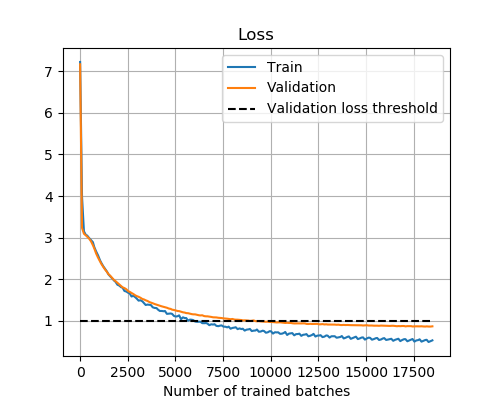

In [40]:
# YOUR CODE HERE
translator = Translator(input_size=input_lang.n_words,
                             embedding_size=30,
                             hidden_size=96,
                             output_size=output_lang.n_words,
                             num_layers=3)
translator.to(device)
train(translator, 50, 0.001, 64, train_dataset, val_dataset);

Make sure you get the validation loss down to at least 1.0 before proceeding.

### 2.5 Evaluation

Now we can evaluate how well our translator performs in unseen sentences. The following functions can be used to streamline the translation process.

In [44]:
def tensor2str(t, lang):
    # Remove batch dimension
    t = t[0]
    
    # Get numpy array
    t = t.cpu().numpy()
    
    # Map each index to its corresponding word
    list_words = list(map(lambda i: lang.index2word[i], t))
    
    sentence = ' '.join(list_words)
    return sentence.replace('PAD', '').replace('EOS', '').replace('SOS', '').strip()

def translate_sentence(translator, in_sentence, n_max_preds=10):
    # Transform input sentence into its tensor representation (and add batch dimension)
    input_tensor = sentence2tensor(input_lang, in_sentence)[None, :].to(device=device)
    
    # Translate using the learned translator
    output_tensor = translator.forward_no_teacher(input_tensor, n_max_preds)
    
    # Transform back to a sentence
    out_sentence = tensor2str(output_tensor, output_lang)
    
    return out_sentence

Using them, it's straightforward to translate new sentences from the test set. Note that we're not using teacher forcing anymore, so it's natural to observe some drop in performance (we're also not printing any special word tokens, like `<SOS>`, or `<PAD>`).

In [45]:
n_translations = 10
for n in range(n_translations):
    i = np.random.randint((len(test_dataset)))
    x, y = test_dataset[i]
    input_sentence = tensor2str(x[None,:], input_lang)
    output_sentence = tensor2str(y[None,:], output_lang)
    print('Input:\t\t', input_sentence)
    print('Translation:\t', output_sentence)
    print('Prediction:\t', translate_sentence(translator, input_sentence))
    print('')

Input:		 they are about to start
Translation:	 ellos están por empezar
Prediction:	 a lo de empezar por empezar

Input:		 he finished breakfast
Translation:	 él terminó su desayuno
Prediction:	 sus libros

Input:		 whose food is this
Translation:	 de quién es esta comida
Prediction:	 de esta libro está ocupado de esto

Input:		 do you like snow
Translation:	 te gusta la nieve
Prediction:	 a verte

Input:		 i ll buy one
Translation:	 voy a comprar uno
Prediction:	 este libro

Input:		 he often comes late
Translation:	 suele venir tarde
Prediction:	 a la cama tarde

Input:		 i like walking by myself
Translation:	 me gusta caminar solo
Prediction:	 a mí caminar aquí me hacer

Input:		 is tom still sleeping
Translation:	 tom sigue durmiendo
Prediction:	 tom todavía todavía está durmiendo

Input:		 i d like to buy that one
Translation:	 quisiera comprar ese
Prediction:	 eso comprar comprar eso

Input:		 tom isn t ready to be a father
Translation:	 tom no está preparado para ser padre
Predic

And we can also translate other sentences we want to (just remember that the input sentence can only contain words from the vocabulary we used to train).

In [46]:
translate_sentence(translator, 'this is a test sentence')

'es una película aquí una verdad'

Finally, in order to get a higher-level view of the performance of your translator across the entire test set, we can compute its [BLEU score](https://en.wikipedia.org/wiki/BLEU). This is a metric whose value ranges from 0 to 1, higher values meaning that the translations are closer to ground-truth. However, only a perfect match between prediction and ground-truth yields a value of 1, so very few translations will be this high. The original [BLEU paper](https://www.aclweb.org/anthology/P02-1040) gives one report of a human baseline for a dataset they used:

> (...) on a test corpus of about 500 sentences (40 general news stories), a human translator scored 0.3468 against four references and scored 0.2571 against two references.

To compute this metric, we use the `nltk` package:

In [47]:
from nltk.translate.bleu_score import corpus_bleu

references = []
preds = []
for i, (x, y) in enumerate(test_dataset):
    input_sentence = tensor2str(x[None, :], input_lang)
    output_sentence = tensor2str(y[None, :], output_lang)
    translated = translate_sentence(translator, input_sentence)   
    references.append([output_sentence.split()])
    preds.append(translated.split())
    
    if i % 1000 == 0 and i != 0:
        print(i, 'sentences processed...')

bleu = corpus_bleu(references, preds)
print('Finished! The BLEU score is: {}'.format(bleu))

1000 sentences processed...
2000 sentences processed...
3000 sentences processed...
4000 sentences processed...
5000 sentences processed...
Finished! The BLEU score is: 0.1769754222935331


For us, a value ranging from 0.1 - 0.2 is reasonable (note that performance can be sensitive to the initialization of the network, so it might vary among different runs of the same optimization), specially since we're only comparing to one reference translation.

You have now completed HA2. **Good job!**

**Final Question:**
What changes could you make to the translator (e.g. architecture, optimization, data used, etc) to improve the end result of your translations? Make three suggestions.

**Your answer:** 

1. More data
2. Use some kind of attention, which has proven to work very well on ML problems
3. GRU layers?
4. Output layers?
5. Adaptable learning rate?
6. Dropout in GRU (it is starting to overfit)?
7. Larger hidden_size?